## **<div style="text-align: center"> SYNTHESISER </div>**
=======================================================================================================================================

    + this is a sub-system that helps create mel spectrograms corresponding to the text that you give it.
    + this is trained on audio and text pairs on a encoder decoder network with attention based on architecture of Tacotron2.
=======================================================================================================================================



## **SECTION 1**:  Preparing & Preprocessing the dataset 

#### Alignment files

* Audio files have utternces interspersed with pauses and silences.
* Alignment files provide the timestamps for each utterences and helps the sytem track the utternces in the audio files.
* LibriSpeech dataset does'nt provide the Alignment files.
* We use the alignment files contibuted by Corentin J




* The structure of heirarchy of folders is same in the dataset and the alignment files
* we prepare the dataset by copying the **alignment.txt** files into each chapter directories from their respective folders in the alignments dataset

**Find the alignment files here**  - <a href = "">alignment files<a>


### Imports

In [11]:
from  pathlib import Path
import shutil
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Adding the alignment files speaker dirs  

In [16]:
# dataset_root = Path("C:/Users/Swaroop/clean-100-with-alignments")
# audio_files  = list(dataset_root.glob("*"))[0]
# alignment_files = list(dataset_root.glob("*"))[1]


# chapter_dir = Path("C:/Users/Swaroop/clean-100-with-alignments/train-clean-100/19/198")

# chapter_dir.relative_to(audio_files)
# count = 3

for speaker_dir in list(audio_files.glob("*")):
    for chapter_dir in list(speaker_dir.glob("*")):
        relative_path = chapter_dir.relative_to(audio_files)
        alignment_file_dir = alignment_files.joinpath(relative_path) 
        
        alignment_file = list(alignment_file_dir.glob("*"))[0] # alignment file path
        
        # print("from :", chapter_dir, "'\nto :", alignment_file_dir,"\nfile: ", alignment_file, "\n\n")
        
        shutil.copy(alignment_file, chapter_dir)
    
   
            

### checking to see if any of the alignment file is missing

In [22]:
for speaker_dir in list(audio_files.glob("*")):
    for chapter_dir in list(speaker_dir.glob("*")):
        alignment_file = list(chapter_dir.glob("*.alignment.txt"))
        if len(alignment_file) == 0:
            print("no alignmentfile found here ", speaker_dir.name, "-", chapter_dir.name)


### Preprocessing directories-level methods

**IN THIS SUB-SECTION :**


**`function call heirarchy`** -    **preprocess_dataset**   calls   **preprocesss_speaker**   which inturn calls **preprocess_utterences**

1. We create two directories `audio` and `mels` and a meta-data file called `train.txt`
2. We load each audio file in the dataset into waveforms and split the files into sub-utterences whenever there are silences using the alignment files.
3. After performing basic preprocessng on the waveforms of the sub utterences we generate their mel-spectrograms.
4. These wavforms and mel spectrograms then stored into `audio` and mel `directories` repectively in form of numpy files with extensions `.npy`.
5. Finally, we store the following meta-data for each file into the `train.txt` file

    * audio file name
    * mels file name
    * embeds file name
    * len of the waveform 
    * the number of mel frames
    * the corresponding text




###  Applying preprocesing

find all the preprocessing functions in the `synthesizer.preprocess` module

In [ ]:
from synthesizer.preprocess import * 
dataset_root = Path("C:/Users/Swaroop/clean-100-with-alignments/train-clean-100")
out_dir = Path("synthesizer/outdir")
out_dir.mkdir(exist_ok= True)
preprocess_dataset(dataset_root, out_dir)

## **SECTION 2**:  Generating the embeddings

We use the previously created encoder model to generate the embedding of all the the audio files and store them into a `Embeds` directory

* we first use the encoder architecture description and load model weights from the stored model `encoder.pt` file.
* further we use `embed_utterences()` method from the encoder's inference module to create the embeddings of the audio files

In [8]:
import torch
from pathlib import Path
import numpy as np



def get_fpaths(synthesizer_root: Path):
    """_summary_ function is designed to return a list of tuples containing (wav_fpath, embed_fpath) 
        wav_fpath is the path of audio file to be embedded
        embed_path is the destination at which the embed will be stored.
     
    """
    wav_dir = synthesizer_root.joinpath("outdir/audio")
    metadata_fpath = synthesizer_root.joinpath("outdir/train.txt")
    assert wav_dir.exists() and metadata_fpath.exists()
    embed_dir = synthesizer_root.joinpath("embeds")
    embed_dir.mkdir(exist_ok=True)

    # Gather the input wave filepath and the target output embed filepath
    
        
    # metadata_fpath = Path(".synths/outdir/train.txt")
    metadata = []
    _tuple = None
    with metadata_fpath.open("r") as metadata_file:
        for line in metadata_file:
            utterence = line.split("|")
            for sub_utterance in utterence:
                _tuple = eval(sub_utterance)
                metadata.append(_tuple)
            
    fpaths = [(wav_dir.joinpath(m[0]), embed_dir.joinpath(m[2])) for m in metadata]
        
        
    return fpaths   

    # for fpath in fpaths:
    #     embed_utterance(fpath, encoder_model_fpath)
    

generating the embeds

In [12]:
from encoder.model import SpeakerEncoding
from encoder.audio import wav_to_mel_spectrogram
import numpy as np
 
fpaths = get_fpaths(Path("./synthesizer")) 
weights_path = Path("C:/Users/Swaroop/OneDrive/Documents/Real-Time-Voice-Cloning-master/saved_models/default/encoder.pt")  #provide the encoder weights file / encoder.pt file here
_model = SpeakerEncoding()
checkpoint = torch.load(weights_path, map_location= torch.device('cpu'))
_model.load_state_dict(checkpoint["model_state"])
_model.eval()

for fpath in fpaths:
    wav_fpath, embed_fpath = fpath 

    wav = np.load(Path(wav_fpath))    
    mel = wav_to_mel_spectrogram(wav)    
    embeds = _model.forward(torch.Tensor(mel))
    np.save(embed_fpath, embeds.detach().numpy(),allow_pickle=False)
    
    

In [22]:
from encoder.audio import preprocess_wav
from encoder import inference2 as encoder



def embed_utterances(fpaths, encoder_model_fpath):
    
    if not encoder.is_loaded():
        encoder.load_model(encoder_model_fpath)

    # Compute the speaker embedding of the utterance
    wav_fpath, embed_fpath = fpaths
    wav = np.load(wav_fpath)
    wav = preprocess_wav(wav)
    embed = encoder.embed_utterance(wav)
    
    print(embed)
    # np.save(embed_fpath, embed, allow_pickle=False)


In [ ]:
fpaths =get_fpaths(synthesizer_root = Path("./synthesizer/"))
print(embed_utterances(fpaths[0],Path("../trained-models/encoder.pt")))

## **NOTE:**
___
### The architecture of the model is described in the Tactron module. We use just simply it from the module to avoid adding unnecessory complexity to our notebook
___

## **SECTION 3:** Model training

### Paths

In [9]:
model_path = Path("../trained-models/encoder.pt")
synthesizer_root = Path("../synthesizer")
metadata_fpath = Path("../synthesizer/outdir/train.txt")
embed_dir = synthesizer_root.joinpath("embeds")
wav_dir = synthesizer_root.joinpath("outdir/audio")



# synthesizer_root.joinpath("outdir/audio")
# create_embeddings(encoder_model_fpath=model_path, synthesizer_root=synthesizer_root)
# len(list(synthesizer_root.joinpath("outdir/audio/").glob("*")))

### Iterating through the train.txt  file

In [42]:
m = []

_tuple = None
with metadata_fpath.open("r") as metadata_file:
    for line in metadata_file:
        utterence = line.split("|")
        for sub_utterance in utterence:
            _tuple = eval(sub_utterance)
            tuples.append(_tuple)
            
        
tuples


[('audio-103-1240-0000_00.npy',
  'mel-103-1240-0000_00.npy',
  'embed-103-1240-0000_00.npy',
  44160,
  221,
  'CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED'),
 ('audio-103-1240-0000_01.npy',
  'mel-103-1240-0000_01.npy',
  'embed-103-1240-0000_01.npy',
  142560,
  713,
  'MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK'),
 ('audio-103-1240-0001_00.npy',
  'mel-103-1240-0001_00.npy',
  'embed-103-1240-0001_00.npy',
  53280,
  267,
  'THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF THE OLD CUTHBERT PLACE'),
 ('audio-103-1240-0001_01.npy',
  'mel-103-1240-0001_01.npy',
  'embed-103-1240-0001_01.npy',
  109440,
  548,
  'IT WAS REPUTED TO BE AN INTRICATE HEADLONG BROOK IN ITS EARLIER COURSE THROUGH THOSE WOODS WITH DARK SECRETS OF POOL AND CASCADE'),
 ('audio-103-1240-0001_02.npy',
  'mel-103-1240-0001_02.npy',
  'embed-103-1240-0001_02.npy',
  68160,
  341,
  "BUT BY THE TIME IT RE

### Synthesizer-Dataset

* `SynthesizerDataset` is a class that  stores the metadata about the dataset and helps in feeding of data into the model during the model training.
* It performs text cleaning using parsers and converts text into sequence data to be fed to the model alongside mels spectrograms

#### testing synthesizer-dataset

In [3]:
from functools import partial
from pathlib import Path
from torch.utils.data import DataLoader
from synthesizer.synthesizer_dataset import SynthesizerDataset
from synthesizer.synthesizer_dataset import collate_synthesizer 
from synthesizer.hparams import hparams

dataset = SynthesizerDataset(Path("./synthesizer/outdir/train.txt"), Path("./synthesizer/outdir/mels/"), Path("./synthesizer/embeds/"))
collate_fn = partial(collate_synthesizer, r=2,hparams = hparams)
data_loader = DataLoader(dataset, 16, shuffle=True, collate_fn=collate_fn)

print("starting loop")
for i, (texts, mels, embeds, idx) in enumerate(data_loader, 1):
    print(texts)
    break
            

Using inputs from:
	synthesizer\outdir\train.txt
	synthesizer\outdir\mels
	synthesizer\embeds
Found 223 samples
starting loop
tensor([[29, 48, 47,  ...,  0,  0,  0],
        [50, 32, 39,  ...,  0,  0,  0],
        [36, 65, 35,  ...,  0,  0,  0],
        ...,
        [40, 28, 47,  ...,  0,  0,  0],
        [42, 35, 65,  ...,  0,  0,  0],
        [28, 30, 30,  ...,  0,  0,  0]])


### Train function

In [1]:
from datetime import datetime
from functools import partial
from pathlib import Path

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
# from synthesizer.synthesizer_dataset import SynthesizerDataset, collate_synthesizer

import synthesizer.audio
from synthesizer.tacotron import Tacotron
from synthesizer.utils.symbols import symbols
from synthesizer.utils.text import sequence_to_text
from synthesizer.hparams import hparams

from synthesizer.train import *

def train(run_id: str, syn_dir: Path, models_dir: Path, save_every: int, force_restart: bool):

    models_dir.mkdir(exist_ok=True)

    model_dir = models_dir.joinpath(run_id)
    plot_dir = model_dir.joinpath("plots")
    wav_dir = model_dir.joinpath("wavs")
    mel_output_dir = model_dir.joinpath("mel-spectrograms")
    meta_folder = model_dir.joinpath("metas")
    model_dir.mkdir(exist_ok=True)
    plot_dir.mkdir(exist_ok=True)
    wav_dir.mkdir(exist_ok=True)
    mel_output_dir.mkdir(exist_ok=True)
    meta_folder.mkdir(exist_ok=True)

    weights_fpath = model_dir / f"synthesizer.pt"
    metadata_fpath = syn_dir.joinpath("train.txt")

    print("Checkpoint path: {}".format(weights_fpath))
    print("Loading training data from: {}".format(metadata_fpath))
    print("Using model: Tacotron")
    
    # Instantiate Tacotron Model
    print("\nInitialising Tacotron Model...\n")
    model = Tacotron(embed_dims=hparams.tts_embed_dims,
                     num_chars=len(symbols),
                     encoder_dims=hparams.tts_encoder_dims,
                     decoder_dims=hparams.tts_decoder_dims,
                     n_mels=hparams.num_mels,
                     fft_bins=hparams.num_mels,
                     postnet_dims=hparams.tts_postnet_dims,
                     encoder_K=hparams.tts_encoder_K,
                     lstm_dims=hparams.tts_lstm_dims,
                     postnet_K=hparams.tts_postnet_K,
                     num_highways=hparams.tts_num_highways,
                     dropout=hparams.tts_dropout,
                     stop_threshold=hparams.tts_stop_threshold,
                     speaker_embedding_size=hparams.speaker_embedding_size)

    # Initialize the optimizer
    optimizer = optim.Adam(model.parameters())

    # Load the weights
    if force_restart or not weights_fpath.exists():
        print("\nStarting the training of Tacotron from scratch\n")
        model.save(weights_fpath)

        # Embeddings metadata
        char_embedding_fpath = meta_folder.joinpath("CharacterEmbeddings.tsv")
        with open(char_embedding_fpath, "w", encoding="utf-8") as f:
            for symbol in symbols:
                if symbol == " ":
                    symbol = "\\s"  # For visual purposes, swap space with \s

                f.write("{}\n".format(symbol))

    else:
        print("\nLoading weights at %s" % weights_fpath)
        model.load(weights_fpath, optimizer)
        print("Tacotron weights loaded from step %d" % model.step)

    # Initialize the dataset
    metadata_fpath = syn_dir.joinpath("outdir/train.txt")
    mel_dir = syn_dir.joinpath("outdir/mels")
    embed_dir = syn_dir.joinpath("embeds")
    dataset = SynthesizerDataset(metadata_fpath, mel_dir, embed_dir)
    for i, session in enumerate(hparams.tts_schedule):
        current_step = model.get_step()

        r, lr, max_step, batch_size = session
        print(r, lr, max_step, batch_size)
        training_steps = max_step - current_step

        # Do we need to change to the next session?
        if current_step >= max_step:
            # Are there no further sessions than the current one?
            if i == len(hparams.tts_schedule) - 1:
                # We have completed training. Save the model and exit
                model.save(weights_fpath, optimizer)
                break
            else:
                # There is a following session, go to it
                continue

        model.r = r

        for p in optimizer.param_groups:
            p["lr"] = lr

        collate_fn = partial(collate_synthesizer, r=r, hparams=hparams)
        data_loader = DataLoader(dataset, batch_size, shuffle=True, collate_fn=collate_fn)

        total_iters = len(dataset)
        steps_per_epoch = np.ceil(total_iters / batch_size).astype(np.int32)
        epochs = np.ceil(training_steps / steps_per_epoch).astype(np.int32)
        print("starting the training...")
        for epoch in range(1, epochs+1):
            print("epoch:  " , epoch)
            for i, (texts, mels, embeds, idx) in enumerate(data_loader, 1):
                print("inside", i)
                # start_time = time.time()

                # Generate stop tokens for training
                stop = torch.ones(mels.shape[0], mels.shape[2])
                for j, k in enumerate(idx):
                    stop[j, :int(dataset.metadata[k][4])-1] = 0

                print("Forward")
                m1_hat, m2_hat, attention, stop_pred = model(texts, mels, embeds)

                # Backward pass
                m1_loss = F.mse_loss(m1_hat, mels) + F.l1_loss(m1_hat, mels)
                m2_loss = F.mse_loss(m2_hat, mels)
                stop_loss = F.binary_cross_entropy(stop_pred, stop)

                loss = m1_loss + m2_loss + stop_loss
                print(loss)

                optimizer.zero_grad()
                loss.backward()

                if hparams.tts_clip_grad_norm is not None:
                    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), hparams.tts_clip_grad_norm)
                    if np.isnan(grad_norm.cpu()):
                        print("grad_norm was NaN!")

                optimizer.step()
                step = model.get_step()
                k = step // 1000



                if save_every != 0 and step % save_every == 0 :
                    # Must save latest optimizer state to ensure that resuming training
                    # doesn't produce artifacts
                    print("saving :",  step)
                    model.save(weights_fpath, optimizer)

                # Evaluate model to generate samples
                epoch_eval = hparams.tts_eval_interval == -1 and i == steps_per_epoch  # If epoch is done
                step_eval = hparams.tts_eval_interval > 0 and step % hparams.tts_eval_interval == 0  # Every N steps
                if epoch_eval or step_eval:
                    for sample_idx in range(hparams.tts_eval_num_samples):
                        # At most, generate samples equal to number in the batch
                        if sample_idx + 1 <= len(texts):
                            # Remove padding from mels using frame length in metadata
                            mel_length = int(dataset.metadata[idx[sample_idx]][4])
                            mel_prediction = np_now(m2_hat[sample_idx]).T[:mel_length]
                            target_spectrogram = np_now(mels[sample_idx]).T[:mel_length]
                            attention_len = mel_length // model.r

                            eval_model(attention=np_now(attention[sample_idx][:, :attention_len]),
                                       mel_prediction=mel_prediction,
                                       target_spectrogram=target_spectrogram,
                                       input_seq=np_now(texts[sample_idx]),
                                       step=step,
                                       plot_dir=plot_dir,
                                       mel_output_dir=mel_output_dir,
                                       wav_dir=wav_dir,
                                       sample_num=sample_idx + 1,
                                       loss=loss,
                                       hparams=hparams)

                # Break out of loop to update training schedule
                if step >= max_step:
                    break

            # Add line break after every epoch
            print("")





### Running the train function

In [ ]:
train("1", syn_dir = Path("./synthesizer"), models_dir = Path("./trained-models/synthesizer"), save_every=10, force_restart= False)

## **SECTION 4:** Inference

In [16]:
synthesizer_root = Path("./synthesizer")
metadata_fpath = Path("./synthesizer/outdir/train.txt")
embed_dir = synthesizer_root.joinpath("embeds")
wav_dir = synthesizer_root.joinpath("outdir/audio")
# with metadata_fpath.open("r") as metadata_file:
#         metadata = [line.split("|") for line in metadata_file]

tuples = []        
_tuple = None
with metadata_fpath.open("r") as metadata_file:
        for line in metadata_file:
                utterence = line.split("|")
                for sub_utterance in utterence:
                        _tuple = eval(sub_utterance)
                        tuples.append(_tuple)
metadata = tuples

In [17]:
import numpy as np
synthesizer_root = Path("./synthesizer")
embeds_root = synthesizer_root.joinpath("embeds")

embeds_paths = [m[2] for m in metadata[100:117]]
texts = [m[5] for m in metadata[100:117]]
embeds = [np.load(embeds_root.joinpath(Path(m))) for m in embeds_paths]



In [19]:
from synthesizer.inference import Synthesizer
synthesizer = Synthesizer(Path("./trained-models/synthesizer/1/synthesizer.pt"))
synthesizer.load()
synthesized_spectrograms_my_model = synthesizer.synthesize_spectrograms(texts, embeds)


Trainable Parameters: 30.870M
Loaded synthesizer "synthesizer.pt" trained to step 60

| Generating 1/2

| Generating 2/2


Done.



In [28]:

synthesizer = Synthesizer(Path("./synthesizer/synthesizer.pt"))
synthesizer.load()
synthesized_spectrograms_pre_trained = synthesizer.synthesize_spectrograms(texts, embeds)
# synthesized_spectrograms_pre_trained


Trainable Parameters: 30.870M
Loaded synthesizer "synthesizer.pt" trained to step 295000

| Generating 1/2

| Generating 2/2


Done.



In [10]:
import pickle
with open('synthesiser-output.pkl', 'wb') as file:    
    pickle.dump(synthesized_spectrograms_pre_trained, file)

### COMPARING SYNTHESIZER OUTPUTS

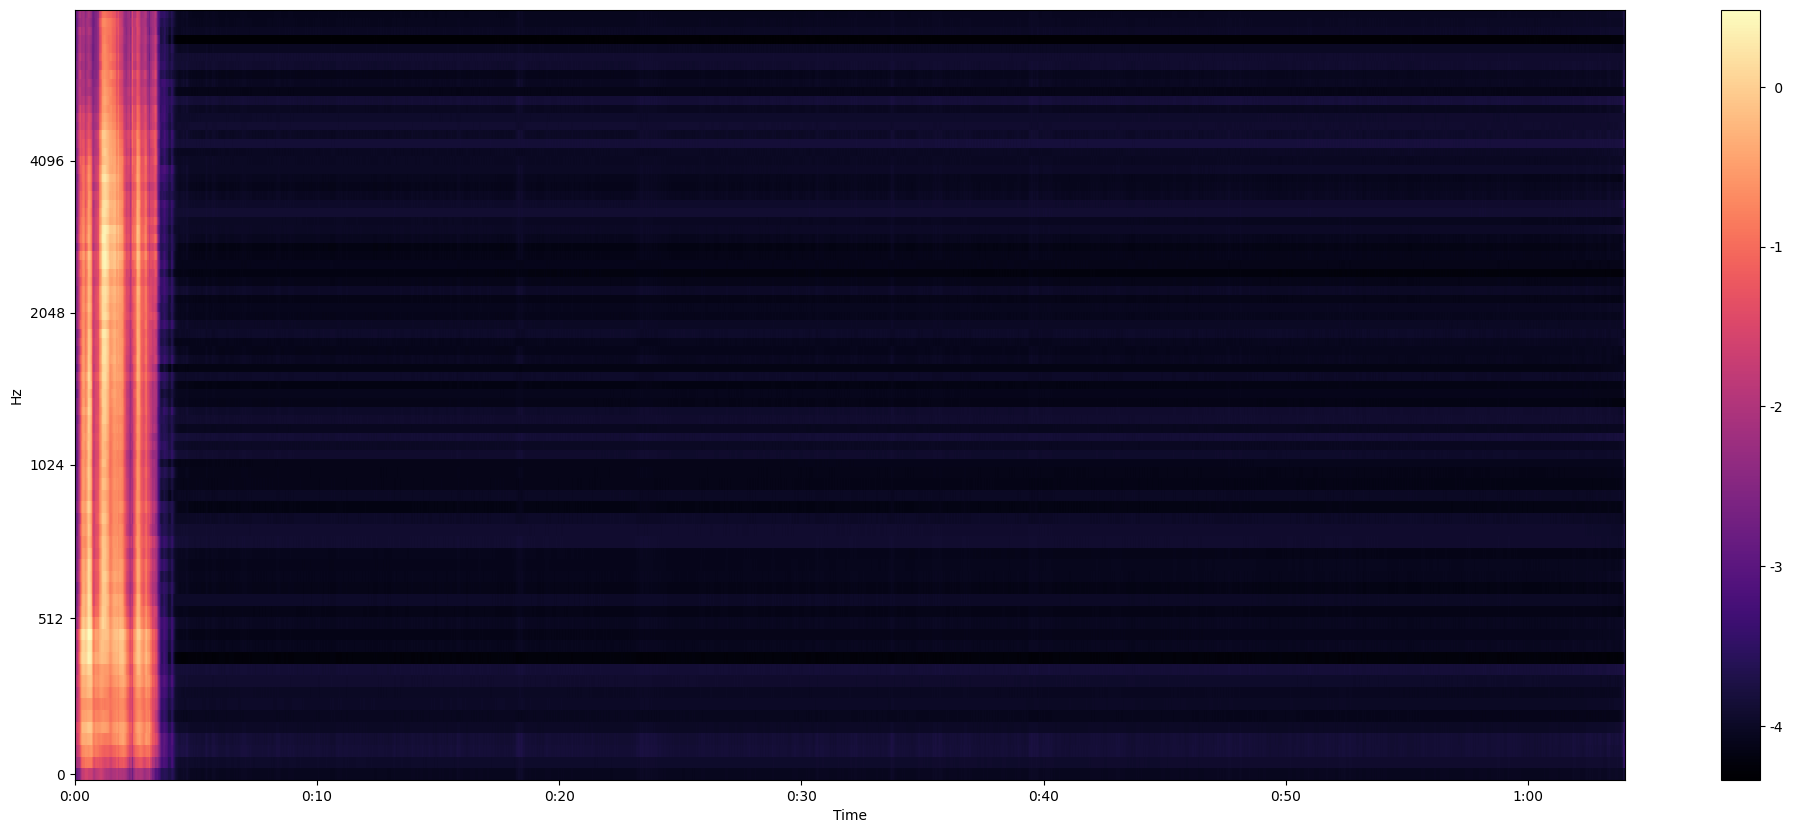

In [20]:
import matplotlib.pyplot as plt
import librosa
import librosa.display 
import IPython.display as ipd

plt.figure(figsize =(25, 10))
librosa.display.specshow(synthesized_spectrograms_my_model[0],
                         x_axis="time",
                         y_axis = "mel",
                         sr = 16000
                         )
plt.colorbar(format = "%2.f")
plt.show()

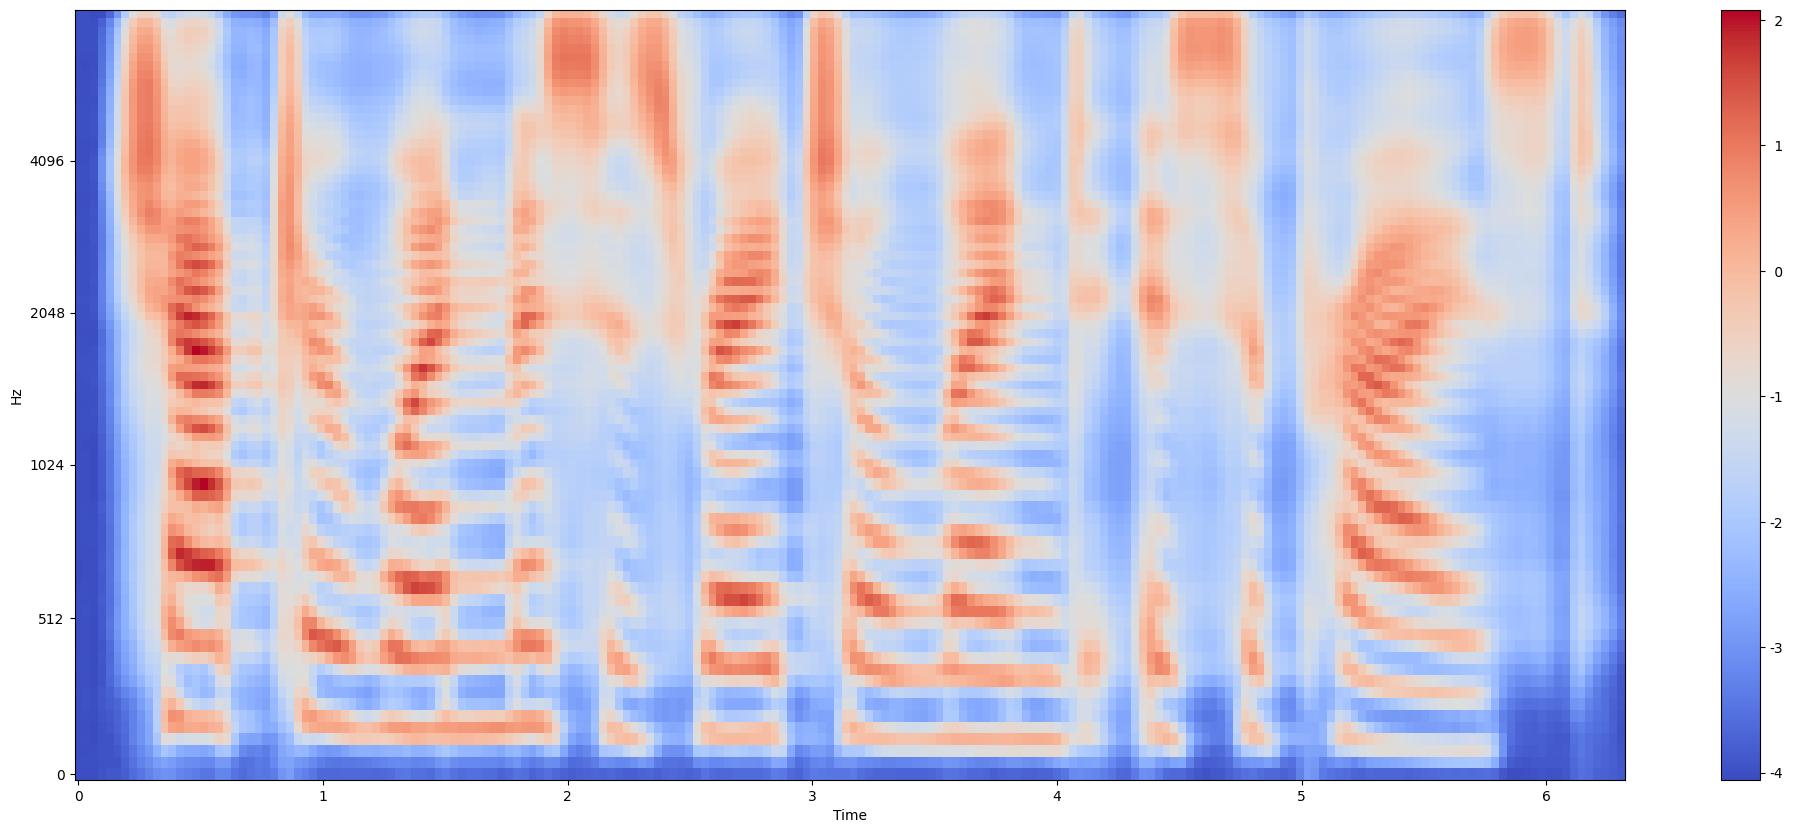

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize =(25, 10))
librosa.display.specshow(synthesized_spectrograms_pre_trained[0],
                         x_axis="time",
                         y_axis = "mel",
                         sr = 16000
                         )
plt.colorbar(format = "%2.f")
plt.show()

In [25]:
import librosa
import librosa.display 
import IPython.display as ipd
import matplotlib.pyplot as plt
from synthesizer.hparams import hparams
from synthesizer.audio import inv_mel_spectrogram

scale = inv_mel_spectrogram(synthesized_spectrograms_my_model[0], hparams= hparams)
ipd.Audio(scale, rate = 16000)

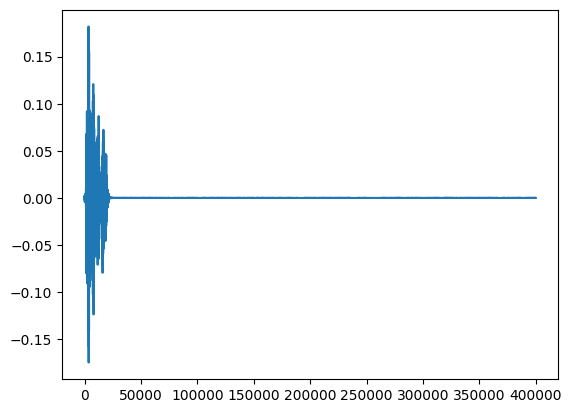

In [26]:
plt.plot(scale)